In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [15]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [16]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [17]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Tải mô hình ResNet50 đã được huấn luyện trước với ImageNet
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Thêm các lớp mới cho mô hình của bạn
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)  # Toàn bộ dữ liệu đầu vào
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_resnet = Dense(2, activation='softmax')(x)  # Số lượng lớp đầu ra tương ứng với số lớp phân loại

# Tạo mô hình hoàn chỉnh
model_resnet = Model(inputs=base_model_resnet.input, outputs=output_resnet)

# Biên dịch mô hình
model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Tóm tắt mô hình
model_resnet.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 23,797,122 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
from tensorflow.keras.applications import ResNet101

# Load the pre-trained ResNet101 model with ImageNet weights
base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

# Add new layers for your model
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)  # Apply global average pooling
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_resnet = Dense(2, activation='softmax')(x)  # Adjust output layer for the number of classes

# Create the full model
model_resnet101 = Model(inputs=base_model_resnet.input, outputs=output_resnet)

# Compile the model
model_resnet101.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_resnet101.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 42,920,706 (163.73 MB)

 Trainable params: 42,815,362 (163.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [20]:
# Huấn luyện mô hình ResNet50
history_resnet50 = model_resnet.fit(train_generator, steps_per_epoch=10, epochs=10, validation_data=valid_generator)
history_resnet101 = model_resnet101.fit(train_generator, steps_per_epoch=10, epochs=10, validation_data=valid_generator)


Epoch 1/10


c:\Users\vohoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - accuracy: 0.5406 - loss: 0.9678 - val_accuracy: 0.5260 - val_loss: 83227.5547
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.7707 - loss: 0.6936 - val_accuracy: 0.5260 - val_loss: 16054.2383
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 117s 12s/step - accuracy: 0.6953 - loss: 0.5761 - val_accuracy: 0.5260 - val_loss: 357835.6250
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 118s 12s/step - accuracy: 0.7480 - loss: 0.5624 - val_accuracy: 0.5260 - val_loss: 1391747.5000
Epoch 5/10
 6/10 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.7866 - loss: 0.5499

c:\Users\vohoa\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.7866 - loss: 0.5561 - val_accuracy: 0.5260 - val_loss: 133193.7344
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.7739 - loss: 0.5033 - val_accuracy: 0.5260 - val_loss: 6207.5532
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.8435 - loss: 0.4068 - val_accuracy: 0.5260 - val_loss: 4104.9194
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.7827 - loss: 0.4780 - val_accuracy: 0.5260 - val_loss: 1232.9829
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.7868 - loss: 0.5552 - val_accuracy: 0.5260 - val_loss: 76.4650
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.7747 - loss: 0.4381 - val_accuracy: 0.5260 - val_loss: 278.3359
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 181s 13s/step - accuracy: 0.6715 - loss: 0.8823 - val_accuracy: 0.4740 - val_loss: 708.0816
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 123s 13s/step - accuracy: 0.7254 - loss: 0.6470 - val_accuracy: 0.526

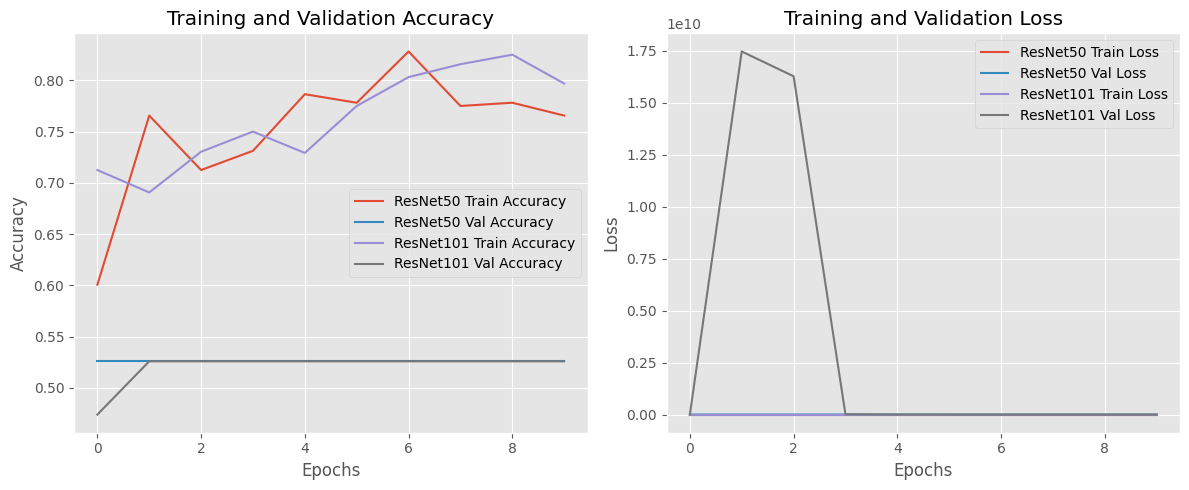

In [21]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Val Accuracy')
plt.plot(history_resnet101.history['accuracy'], label='ResNet101 Train Accuracy')
plt.plot(history_resnet101.history['val_accuracy'], label='ResNet101 Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='ResNet50 Train Loss')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50 Val Loss')
plt.plot(history_resnet101.history['loss'], label='ResNet101 Train Loss')
plt.plot(history_resnet101.history['val_loss'], label='ResNet101 Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
